## Investigating problematic voltage setpoints with pypowsybl-jupyter
- This notebook demonstrates how to **investigate faulty voltage setpoints** with the help of the **network explorer widget**.
- It compares **target voltage** and **calculated voltage** on each generator.
- We will visualize differences by providing the widget a **custom styling** to apply on bus nodes.

#### 1. Loading networks
- We load a french network snapshot, near to the 7pm peak hour.
- We then run an AC loadflow on that snapshot.

In [1]:
import pypowsybl.network as pn
network = pn.load('/home/dupuyflo/Data/LFE_2025/fr_1850.xiidm')

In [2]:
import pypowsybl.loadflow as lf
lf.run_ac(network)

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=Converged, iteration_count=7, reference_bus_id='CHAFFP7_0', slack_bus_results=[SlackBusResult(id='CHAFFP7_0', active_power_mismatch=-0.5088339270259201)], distributed_active_power=28.570841706134765)]

#### 2. Compute voltage differences
- We're constructing the dataframe containing the delta between target_v and calculated v for each generator.
- We're then aggregating that dataframe to have the maximum difference for each bus.

- getting the generators dataframe

In [3]:
gens = network.get_generators(attributes=['target_v', 'bus_id'])
gens

,target_v,bus_id
id,,
.CTLO3GROUP.1,66.150002,.CTLHP3_0
.CTLO3GROUP.2,66.150002,.CTLHP3_1
ARGOEIN2,94.637794,ARGOEP4_0
ARGOEIN1,240.139236,ARGOEP6_0
EGUZO4EGUZOH1+2+3,92.643967,EGUZOP4_0
...,...,...
VOVESIN3,94.162010,VOVESP4_0
WALDIIN1,65.063324,WALDIP3_0
WALDIIN3,65.063324,WALDIP3_0


- getting the buses dataframe

In [4]:
bus_v = network.get_buses(attributes=['v_mag'])
bus_v

,v_mag
id,
.CTLHP3_0,NaN
.CTLHP3_1,NaN
.CTLOP3_0,63.416170
.CTLOP3_3,NaN
.G.ROP6_0,237.940593
...,...
ZVOUZP4_0,94.888962
ZWOESP6_0,235.745697
ZY.EVP4_0,89.873197


- constructing the `delta_v` column

In [5]:
gens['delta_v'] = gens['bus_id'].map(bus_v['v_mag']) - gens['target_v']
gens

,target_v,bus_id,delta_v
id,,,
.CTLO3GROUP.1,66.150002,.CTLHP3_0,NaN
.CTLO3GROUP.2,66.150002,.CTLHP3_1,NaN
ARGOEIN2,94.637794,ARGOEP4_0,0.002372
ARGOEIN1,240.139236,ARGOEP6_0,0.003580
EGUZO4EGUZOH1+2+3,92.643967,EGUZOP4_0,0.000000
...,...,...,...
VOVESIN3,94.162010,VOVESP4_0,0.001405
WALDIIN1,65.063324,WALDIP3_0,0.084915
WALDIIN3,65.063324,WALDIP3_0,0.084915


- looking at extreme values

In [6]:
gens['delta_v'].min(), gens['delta_v'].max()

(np.float64(-0.17822187459366035), np.float64(1.5594544290956094))

In [7]:
gens.sort_values(by='delta_v', key=abs, ascending=False).head(10)

,target_v,bus_id,delta_v
id,,,
H.PUIIN1,93.017090,H.PUIP4_0,1.559454
PERIEIN1,93.179733,PERIEP4_0,0.977998
TOLMEIN1,93.623184,TOLMEP4_1#0,0.589754
VLEDIIN1,92.060165,VLEDIP4_0,0.564439
AGNEAIN1,93.026337,AGNEAP4_0,0.555663
ALERIIN1,93.321419,ALERIP4_0,0.550395
MESNIIN1,92.942345,MESNIP4_0,0.522404
VALCAIN1,93.386345,VALCAP4_0,0.438143
COUTAIN1,92.106506,COUTAP4_0,0.410341


- Taking the maximum value for each bus to aggregate the values

In [8]:
gens = gens.groupby('bus_id').max()
gens

,target_v,delta_v
bus_id,,
,0.000000,NaN
.CTLHP3_0,66.150002,NaN
.CTLHP3_1,66.150002,NaN
A.ADOP3_0,62.077320,-0.052657
A.COMP6_0,240.099899,0.003744
...,...,...
VOUZIP3_0,66.227478,-0.000847
VOVESP4_0,94.162010,0.001405
WALDIP3_0,65.063324,0.084915


#### 3. Construct a style dataframe
  - Green/Red gradient indicate small/big changes
  - Gray indicate NaN values (buses without generators)

In [9]:
import pandas as pd
import numpy as np

red_value_legend = 0.3

def create_style_gradient(n_colors=100):
    r = np.linspace(91, 255, n_colors)
    g = np.linspace(217, 0, n_colors)
    b = np.linspace(179, 0, n_colors)

    colors = ['#{:02x}{:02x}{:02x}'.format(int(r[i]), int(g[i]), int(b[i])) 
              for i in range(n_colors)]

    numeric_widths = np.linspace(1, 15, n_colors)
    width_strings = [f"{int(width)}px" for width in numeric_widths]

    return pd.DataFrame({
        'width': width_strings,
        'hex_color': colors
    })

style_df = create_style_gradient(100)

def map_index(value):
    if pd.isna(value):
        return -1
    return min(int(abs(value) / red_value_legend * 99), 99)


gens['dv_idx'] = gens['delta_v'].apply(map_index)
gens

,target_v,delta_v,dv_idx
bus_id,,,
,0.000000,NaN,-1
.CTLHP3_0,66.150002,NaN,-1
.CTLHP3_1,66.150002,NaN,-1
A.ADOP3_0,62.077320,-0.052657,17
A.COMP6_0,240.099899,0.003744,1
...,...,...,...
VOUZIP3_0,66.227478,-0.000847,0
VOVESP4_0,94.162010,0.001405,0
WALDIP3_0,65.063324,0.084915,28


#### 4. Construct the custom style profile

- first taking the default style profile

In [10]:
default_pf = network.get_default_nad_profile()

- then overriding the bus nodes styles based on the `delta_v` column and on the style dataframe

In [11]:
color = gens['dv_idx'].apply(lambda idx: 'gray' if idx == -1 else style_df['hex_color'].iloc[idx])
width = gens['dv_idx'].apply(lambda idx: '1px' if idx == -1 else style_df['width'].iloc[idx])
bus_nodes_styles_df = pd.DataFrame({
    'fill': color
})
bus_nodes_styles_df.index.name = 'id'
bus_nodes_styles_df

,fill
id,
,gray
.CTLHP3_0,gray
.CTLHP3_1,gray
A.ADOP3_0,#77b394
A.COMP6_0,#5cd6b1
...,...
VOUZIP3_0,#5bd9b3
VOVESP4_0,#5bd9b3
WALDIP3_0,#899b80


- overriding the bus description to see only the calculated v

In [12]:
bus_descriptions_df = pd.DataFrame({
    'description': bus_v['v_mag'].apply(lambda x: f"{x:.3f}kV")
})

- remove unneeded branch labels and voltage level descriptions

In [13]:
vl_descriptions_df = default_pf.vl_descriptions[default_pf.vl_descriptions['type'] != 'FOOTER']
labels_df = pd.DataFrame()

- creating the custom NAD style profile

In [14]:
diagram_profile=pn.NadProfile(branch_labels=labels_df, vl_descriptions=vl_descriptions_df, bus_descriptions=bus_descriptions_df,
                                      bus_node_styles=bus_nodes_styles_df, edge_styles=default_pf.edge_styles)

#### 5. Display the results!

##### _Load the fixed nad positions_

In [15]:
metadata = pd.read_json('/home/dupuyflo/Documents/LFE_2025/france_metadata.json')
fixed_positions = pd.DataFrame({
    "id": metadata["equipmentId"],
    "x": metadata["x"],
    "y": metadata["y"]
})
fixed_positions.set_index('id', drop=True, inplace=True)

##### _Construct a colorbar to display the color legend_

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch

def display_legend(max_value):
    cmap = ListedColormap(style_df["hex_color"].tolist())
    norm = Normalize(vmin=0.0, vmax=max_value)
    
    fig, ax = plt.subplots(figsize=(6, 1.2))
    fig.subplots_adjust(bottom=0.5)
    
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # required for older matplotlib

    cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.3, pad=0.25)
    cbar.set_label("|delta_v|")

    tick_vals = np.linspace(0, max_value, 5)
    cbar.set_ticks(tick_vals)
    cbar.set_ticklabels([f"{v*1e3:.2f} V" for v in tick_vals])  # convert kV -> V for readability

    ax.axis("off")

    ax.legend(handles=[Patch(facecolor="gray", edgecolor="none", label="NaN / unavailable")],
              loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=1, frameon=False)

    plt.show()

##### _Display the widget_

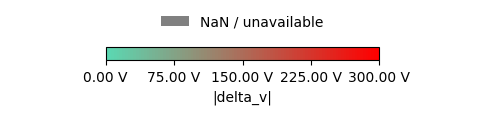

In [17]:
from pypowsybl_jupyter import network_explorer

display_legend(red_value_legend)
network_explorer(network, depth=2, vl_id='PERIEP4', nad_profile=diagram_profile, fixed_nad_positions=fixed_positions, nad_parameters=pn.NadParameters(injections_added=True))